# <a id='toc1_'></a>[Sensitivity of cDNA vs vRNA probing](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Sensitivity of cDNA vs vRNA probing](#toc1_)    
  - [Summary](#toc1_1_)    
  - [Data loading](#toc1_2_)    
  - [Split and filter data](#toc1_3_)    
    - [Split treated/control and filter infected cells](#toc1_3_1_)    
    - [QC: sample dropouts (no infected cells)](#toc1_3_2_)    
    - [Summarize spots per (infected) cell](#toc1_3_3_)    
    - [QC distribution of number of infected cells](#toc1_3_4_)    
    - [QC spot count outliers (failed segmentation):](#toc1_3_5_)    
  - [Spots by Sample](#toc1_4_)    
  - [Numbers for main text](#toc1_5_)    
    - [Percentage of spots in the nucleus](#toc1_5_1_)    
    - [Percentage of infected cells](#toc1_5_2_)    
    - [Spots per infected cell](#toc1_5_3_)    
    - [Combine above tables into one](#toc1_5_4_)    
    - [Difference between cDNA with and without RCA primer](#toc1_5_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Summary](#toc0_)

The sensitivity and specificity of cDNA probing, cDNA with RCA primer (cDNA*), and direct vRNA probing is compared.

The following settings was used:
- only spots from infected cells (at least 5 spots), discarding all other spots - exception: negative controls (cells are not infected so we keep all spots)
- include spots from the cytoplasm and the nucleus
- include inner cells and border cells in the analysis (see QC below)
- do not crop images (neighboring fields of view have a slight overlap so counts from these FOVs are not completely independent, this could be problematic for statistical tests (not performed here))

General observations:
- there are far more spots for direct vRNA probing, especially with fewer PLPs

## <a id='toc1_2_'></a>[Data loading](#toc0_)

In [1]:
library(tidyverse)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 4)
theme_set(theme_light())
theme_update(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black'))

In [3]:
# file generated with code/spot_analysis/combind_csvs.R
spots <- read_tsv("analysis/spot_detection/cDNA_vRNA/all_spots.tsv.xz") %>%
  mutate(molecule=str_replace(molecule, "cDNA_RCAprimer", "cDNA*"))

Rows: 318653 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): rep, molecule, sample, fov
dbl (17): intensity, z, y, x, radius, spot_id, z_min, z_max, y_min, y_max, x...
lgl  (2): nucleus, border_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## <a id='toc1_3_'></a>[Split and filter data](#toc0_)

For negative controls, all spots are used and the number of spots per cell is calculated. For all other samples, only spots from *infected* cells are used and the number of spots per infected cell is calculated.
A cell is defined as *infected* if at least 5 spots are assigned to that cell, including the nucleus.

### <a id='toc1_3_1_'></a>[Split treated/control and filter infected cells](#toc0_)

In [4]:
pos_spots <- spots %>%
	filter(!str_detect(sample,"NegCtrl")) %>%
	group_by(rep,molecule,sample,fov,cell) %>%
	filter(n()>=5) %>%
	group_by(rep,molecule,sample,fov) %>%
	mutate(infected_cells=n_distinct(cell))

In [5]:
neg_spots <- spots %>%
	filter(str_detect(sample,"NegCtrl"))

### <a id='toc1_3_2_'></a>[QC: sample dropouts (no infected cells)](#toc0_)

After filtering cells with less than 5 spots, some samples are lost as they don't contain any infected cells.

This affects particularly the cDNA 1PLP samples. Sensitivity in this setting seems to be very low.

In [6]:
get_fovs <- . %>% ungroup %>% select(rep,molecule,sample,fov) %>% unique

In [7]:
fovs_no_infected_cells <- get_fovs(spots %>% filter(!str_detect(sample,"NegCtrl"))) %>% anti_join(get_fovs(pos_spots))
fovs_no_infected_cells

Joining with `by = join_by(rep, molecule, sample, fov)`


rep,molecule,sample,fov
<chr>,<chr>,<chr>,<chr>
rep1,cDNA,1PLP,fov_1
rep1,cDNA,1PLP,fov_2
rep1,cDNA,1PLP,fov_3
rep1,cDNA,1PLP,fov_4
rep1,cDNA,1PLP,fov_5
rep1,cDNA,1PLP,fov_6
rep1,cDNA,1PLP,fov_8
rep1,cDNA,1PLP,fov_9
rep2,cDNA*,5PLP,fov_0


### <a id='toc1_3_3_'></a>[Summarize spots per (infected) cell](#toc0_)

In [8]:
pos_spots_summary <- pos_spots %>% group_by(rep,molecule,sample,fov,infected_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_infected_cell = spots/infected_cells)
neg_spots_summary <- neg_spots %>% group_by(rep,molecule,sample,fov,n_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_cell = spots/n_cells)

`summarise()` has grouped output by 'rep', 'molecule', 'sample', 'fov'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'rep', 'molecule', 'sample', 'fov'. You can
override using the `.groups` argument.


### <a id='toc1_3_4_'></a>[QC distribution of number of infected cells](#toc0_)

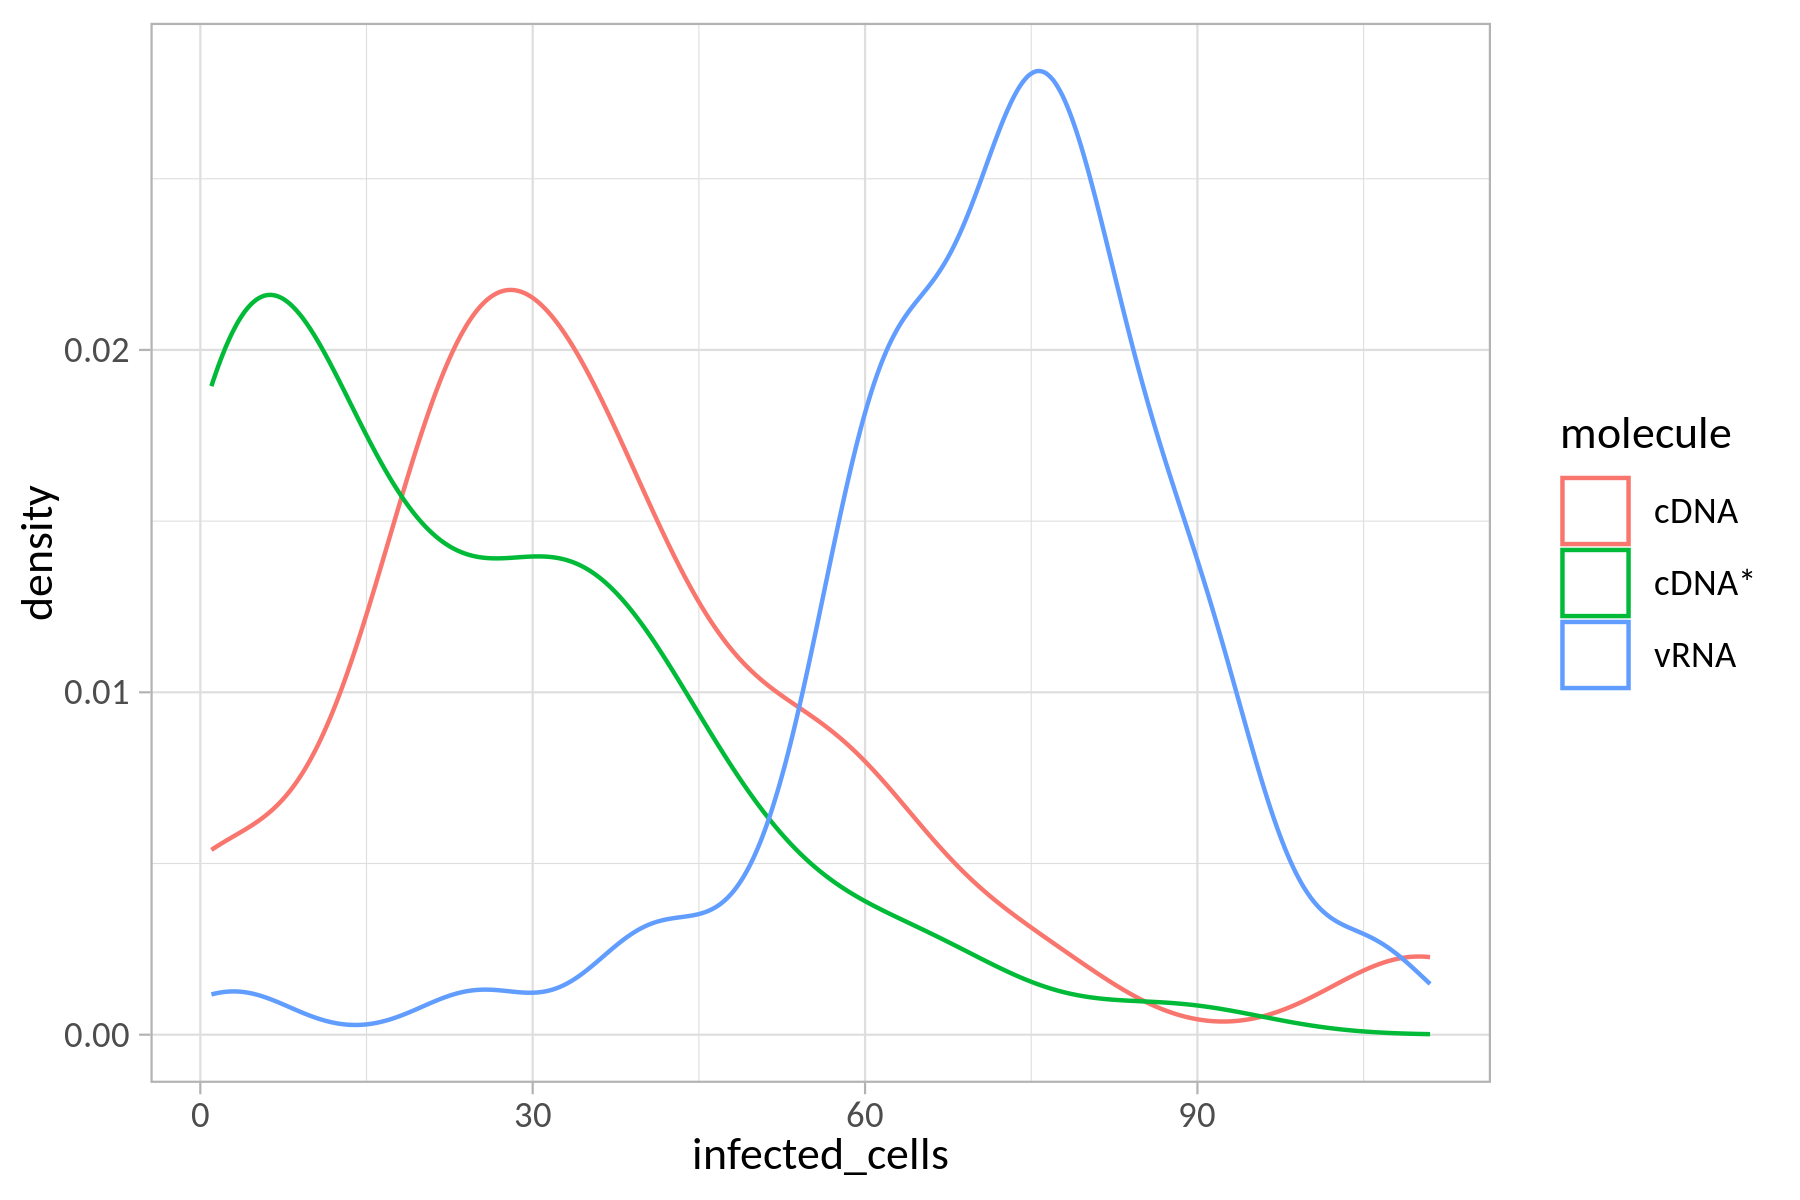

In [9]:
pos_spots_summary %>% ggplot(aes(x=infected_cells, color=molecule)) + geom_density()

The number of infected cells should be roughly equal for all molecules. This plot indicates, that the number of cells detected as infected differs. Already hinting at different sensitivities.

### <a id='toc1_3_5_'></a>[QC spot count outliers (failed segmentation):](#toc0_)

In some cases the segmentation may fail and very few nuclei are detected, therefore the spots/cell count would be massively inflated. Those samples need to be filtered.

In [10]:
pos_spots_summary %>% filter(spots_per_infected_cell>1000)

rep,molecule,sample,fov,infected_cells,spots,median_intensity,mean_radius,spots_per_infected_cell
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>


In [11]:
pos_spots_summary <- pos_spots_summary %>% filter(spots_per_infected_cell < 1000)
neg_spots_summary <- neg_spots_summary %>% filter(spots_per_cell < 1000)

## <a id='toc1_4_'></a>[Spots by Sample](#toc0_)

Warning: one outlier sample with 196 spots per cell in 5PLP vRNA not shown.

In [12]:
pos_plot <- pos_spots_summary %>%
	mutate(plp = parse_number(sample)) %>%
	ggplot(aes(plp,spots_per_infected_cell))+#,color=segment)) +
		geom_jitter(width=.5)+
		geom_boxplot(aes(group=plp), outlier.shape = NA) +
		facet_grid(molecule ~ plp, scale="free_x") +
		scale_x_continuous(breaks = c(1,5,10)) +
		coord_cartesian(ylim=c(0,100)) +
		xlab("PLPs per target") + ylab("RCPs per infected cell") +
		# scale_y_log10() +
		NULL

In [13]:
ggsave("figures/fig1c-cDNA_vRNA-spot_counts.svg", width = 4.5, height = 4, dpi = 300)

In [14]:
neg_plot <- neg_spots_summary %>%
	ggplot(aes(sample,spots_per_cell))+#,color=segment)) +
		geom_jitter()+#aes(color=rep)) +
		geom_boxplot(aes(group=sample), outlier.shape = NA) +
		facet_grid(molecule ~ .) +
		coord_cartesian(ylim=c(0,100)) +
		scale_x_discrete(breaks = NULL) +
		xlab("Neg. Control") + ylab("RCPs per cell") +
		NULL

In [15]:
ggsave("figures/supp-fig1b-cDNA_vRNA-spot_counts-neg_ctrl.svg", width = 2, height = 4, dpi = 300)

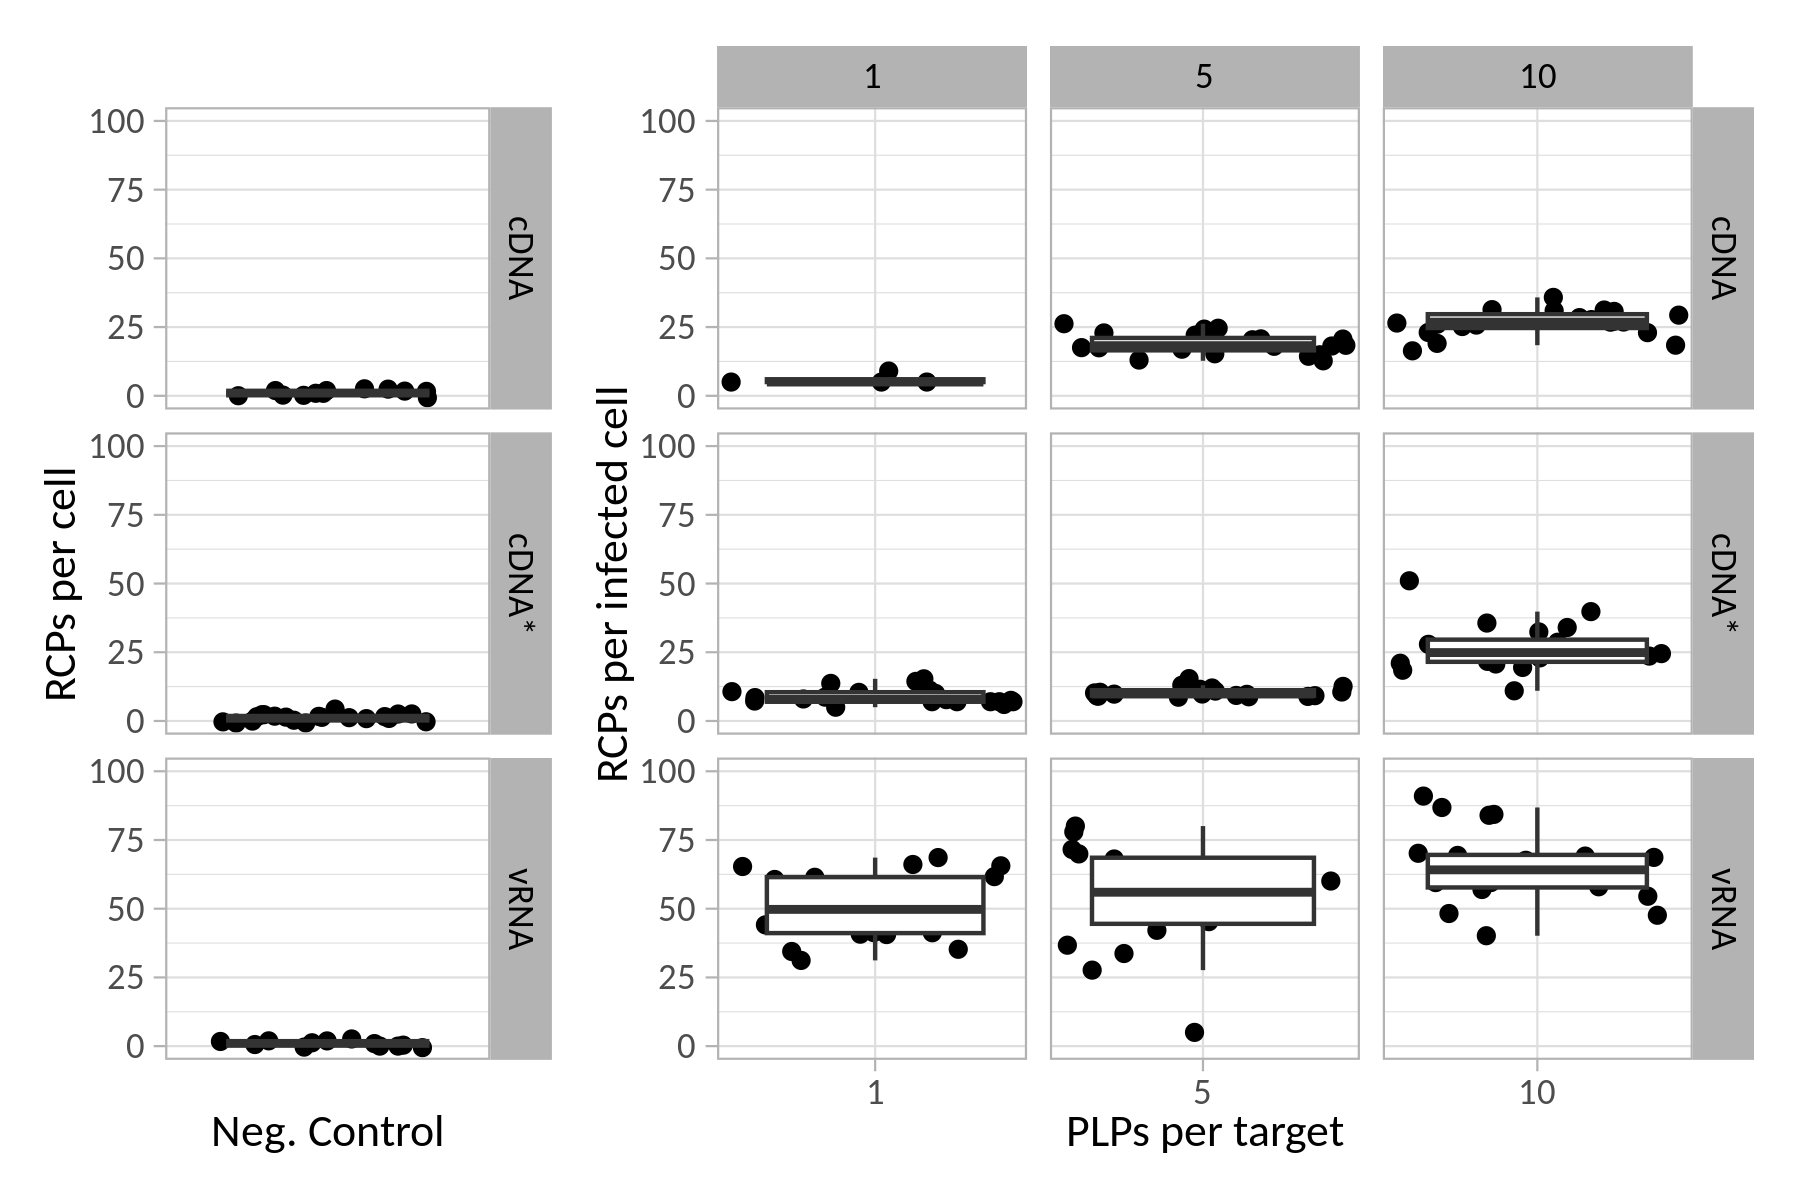

In [16]:
neg_plot + pos_plot + plot_layout(widths = c(1, 3)) #& scale_y_continuous(limits = c(0, 45)) 

## <a id='toc1_5_'></a>[Numbers for main text](#toc0_)

Percentage of spots in the nucleus

In [17]:
percent_nucleus <- spots %>%
  filter(sample!="NegCtrlPLP") %>%
  group_by(molecule, sample) %>%
  summarize(nuc = sum(nucleus)/n()) %>%
  ungroup %>%
  arrange(molecule, parse_number(sample))

`summarise()` has grouped output by 'molecule'. You can override using the
`.groups` argument.


Percentage of infected cells

In [18]:
percent_infected <- spots %>%
	filter(!str_detect(sample,"NegCtrl")) %>%
	group_by(rep,molecule,sample,fov,cell) %>%
	summarize(infected=n()>=5) %>%
  group_by(molecule,sample) %>%
  summarize(infected=mean(infected)) %>%
  ungroup %>%
  arrange(molecule, parse_number(sample))

`summarise()` has grouped output by 'rep', 'molecule', 'sample', 'fov'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'molecule'. You can override using the
`.groups` argument.


Spots per infected cell

In [19]:
spots_per_infected <- pos_spots_summary %>%
  mutate(spots = spots_per_infected_cell*infected_cells) %>% # go back to total spots to aggregate across reps and fovs
  group_by(molecule,sample) %>%
  summarize(infected_cells = sum(infected_cells), spots = sum(spots), spots_per_infected_cell = spots/infected_cells)

`summarise()` has grouped output by 'molecule'. You can override using the
`.groups` argument.


Combine above tables into one

In [20]:
combined <- left_join(percent_nucleus, percent_infected, by=c("molecule","sample")) %>%
  left_join(spots_per_infected, by=c("molecule","sample"))
combined

molecule,sample,nuc,infected,infected_cells,spots,spots_per_infected_cell
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
cDNA,1PLP,0.8272425,0.0195122,4,24,6.000000
cDNA,5PLP,0.8353197,0.4573820,601,11122,18.505824
cDNA,10PLP,0.6613484,0.5286526,1024,27662,27.013672
cDNA*,1PLP,0.8511128,0.1198428,61,577,9.459016
cDNA*,5PLP,0.8576760,0.3676341,418,4469,10.691388
cDNA*,10PLP,0.7774279,0.6557998,865,22616,26.145665
vRNA,1PLP,0.6763871,0.9801061,1478,74219,50.215832
vRNA,5PLP,0.5846468,0.9534731,1455,83430,57.340206
vRNA,10PLP,0.5754792,0.9529164,1356,87350,64.417404
